In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import simulate
import seaborn as sns
import calculate_return as cr
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 1000)

In [108]:
spx = pd.read_csv('^GSPC.csv', index_col=0,parse_dates=True)

### Defining market to simulate

In [109]:
start = dt.date(2020, 1, 1)
end = dt.date(2060, 1, 1)
Market = simulate.Market(spx.iloc[-7500:, -2], start, end)

Simulating data

In [ ]:
garch = Market.garch(log=False)
tdist = Market.t_innovations(log=False)
draw = Market.draw(log = False, with_replacement = True, freq = 'D')
norm = Market.norm_innovations(log=False)
empirical=spx.iloc[-10437:, -2].pct_change().to_frame()

Plotting Returns

In [ ]:
f, ax1= plt.subplots(1, 1, figsize=(15,12))

ax1.plot(empirical['Adj Close'], alpha=.8)
ax1.set_ylabel('Yearly Returns')
ax1.set_ylim((-0.35,0.35))

In [ ]:
f, (ax1,ax2,ax3,ax4,) = plt.subplots(4, 1, figsize=(15,12))

ax1.plot(garch["Price"].pct_change(), alpha=.8)
ax1.set_ylabel('Yearly Returns')
ax1.set_ylim((-0.35,0.35))

ax2.plot(tdist['Price'].pct_change(), alpha=.8)
ax2.set_ylabel('Yearly Returns')
ax2.set_ylim((-0.35,0.35))

ax3.plot(norm['Price'].pct_change(), alpha=.8)
ax3.set_ylabel('Yearly Returns')
ax3.set_ylim((-0.35,0.35))

ax4.plot(draw['Price'].pct_change(), alpha=.8)
ax4.set_ylabel('Yearly Returns')
ax4.set_ylim((-0.35,0.35))

Plotting Histograms of returns

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#sns.kdeplot(data=garch['Price'].pct_change(),clip=(-0.1, 0.1),Label='GJR-GARCH(1,1)')
#sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

#sns.kdeplot(data=tdist['Price'].pct_change(),clip=(-0.1, 0.1),Label='Skewed Students t-distribution')
#sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

#sns.kdeplot(data=norm['Price'].pct_change(),clip=(-0.1, 0.1),Label='Normal distribution')
#sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

sns.kdeplot(data=draw['Price'].pct_change(),clip=(-0.1, 0.1),Label='Draw with Replacement')
sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

plt.xlabel('Returns') 
plt.ylabel('Probability Density') 


In [ ]:
garch = Market.garch(log=False)
naive = Market.t_innovations(log=False)
draw = Market.draw(log = False, with_replacement = True, freq = 'D')
norm = Market.norm_innovations(log=False)

f, (ax1, ax2 , ax3) = plt.subplots(3, 1, figsize=(15,12))
ax1.plot(garch["Price"], alpha=.8)
ax1.plot(naive['Price'], alpha=.8)
ax1.plot(draw['Price'], alpha=.8)
ax1.plot(norm['Price'], alpha=.8)
ax1.set_title('Market')
ax1.legend(['garch', 'naive_t', 'draw with replace', 'naive_norm'])
ax1.set_yscale('log')

ax2.plot(garch["data"], alpha=.5)
ax2.plot(naive['Price'].pct_change()*100+20, alpha=.5)
ax2.plot(draw['Price'].pct_change()*100+40, alpha=.5)
ax2.plot(norm['Price'].pct_change()*100+60, alpha=.5)
ax2.set_ylim(-20, 80)
ax2.set_title('returns')
#ax2.set_yscale('LOG')

ax3.plot(garch["volatility"])
ax3.set_title('Volatility')
#ax3.set_yscale('LOG')

Simulating many markets

In [ ]:
def many_market(market, num_simulations):
    '''
    this simulated nobs markets with a horizon of years years

    return a dataframe with nobs columns and years*252 rows 
    '''
    data = pd.DataFrame()
    
    for i in range(num_simulations):
        data["Price_" + str(i)] = market.garch(log = True)['Price']
    return data

Descriptive statistic of simulations

In [ ]:
Market = simulate.Market(spx.iloc[-7500:, -2], start, end)
final_returns=many_market(Market, 1000).iloc[-1, :]

In [ ]:
plt.hist(final_returns, bins = 100, histtype='step', range=[-10000, 200000])
plt.show()

Plotting wealth with error

In [115]:
savings_year = pd.read_csv('investment_plan_year.csv', sep=';', index_col=0)
savings_year.index = pd.to_datetime(savings_year.index, format='%Y')
savings_month = (savings_year.resample('BMS').pad() / 12)['Earnings'].values
investments = savings_month * 0.05
ports = cr.fetch_returns(investments = investments,
                         sim_type = 'garch',
                         random_seeds = range(10000),
                         GAMMA = 2.5,
                         YEARLY_RF = 0.02,
                         YEARLY_MR = 0.04,
                         COST = 0.002,
                         save_to_file = False)

In [273]:
def plotter(Variable,n=1000,log=False):
    y = ports[[Variable]].sort_index() 
    #Finder mean og std_afv per periode
    Data = y.groupby(level='period').mean()
    Data['std_dev']=y.groupby(level='period').std()
    Data=Data.rename(columns={Variable:'Mean'})

    #udregner øvre og nedre 95% confidens interval
    Data['Upper band']=Data['Mean']+1.96*Data['std_dev']/np.sqrt(n)
    Data['Lower band']=Data['Mean']-1.96*Data['std_dev']/np.sqrt(n)

    #plotting y with errorband +- error
    plt.plot(Data['Mean'],'-k')
    if log==True:
        plt.yscale('log')
    plt.fill_between(Data.index,Data['Lower band'], Data['Upper band'],alpha=0.5)
    #plt.legend(Variable)



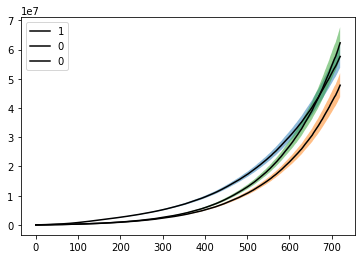

In [274]:
plotter('tv_u')
plotter('9050')
plotter("100")
plt.show()

In [246]:
ports

,savings,cash,new_equity,new_debt,total_debt,nip,pv_p,interest,market_returns,pv_u,tv_u,equity,dst,phase,pi_hat,g_hat,SU_debt,Nordnet_debt,100,9050
period,,,,,,,,,,,,,,,,,,,,
0.000,1666.667,0.000,1666.667,1666.667,1666.667,3333.333,3333.333,0.000,0.000,3333.333,3333.333,1666.667,2251209.542,1.000,0.001,1.000,1666.667,0.000,1666.667,1666.667
1.000,1666.667,0.000,1666.667,1666.667,3333.333,3333.333,6666.667,5.565,0.019,6790.392,6790.392,3457.059,2251209.542,1.000,0.001,0.964,1666.667,0.000,3397.979,3391.765
2.000,1666.667,0.000,1666.667,1790.392,5123.726,3457.059,10247.452,11.543,0.044,10687.409,10687.409,5563.683,2251209.542,1.000,0.002,0.921,3457.059,0.000,5287.792,5259.638
3.000,1666.667,0.000,1666.667,2106.624,7230.350,3773.290,14460.699,18.577,0.017,14691.708,14691.708,7461.358,2251209.542,1.000,0.003,0.969,5563.683,0.000,7074.490,7035.027
4.000,1666.667,0.000,1666.667,1897.675,9128.025,3564.342,18256.050,24.913,0.012,18442.801,18442.801,9314.776,2251209.542,1.000,0.004,0.980,7461.358,0.000,8842.503,8793.869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716.000,8617.500,4910868.984,353783.041,0.000,0.000,353783.041,15668355.990,0.000,-0.070,14572063.206,19482932.190,19482932.190,14833674.139,4.000,0.748,0.000,0.000,0.000,18977404.845,13272908.569
717.000,8617.500,4651314.466,268172.018,0.000,0.000,268172.018,14840235.224,0.000,0.043,15478200.416,20129514.882,20129514.882,15325961.278,4.000,0.769,0.000,0.000,0.000,19802210.309,13727689.176
718.000,8617.500,4805610.019,-145678.052,0.000,0.000,-145678.052,15332522.363,0.000,-0.017,15076580.066,19882190.085,19882190.085,15137656.180,4.000,0.758,0.000,0.000,0.000,19480130.182,13562623.105
